In [1]:
import helper
from helper import *
import importlib
importlib.reload(helper)

df = load_merged_data(only_standard_refuelling=True)

In [2]:
import xgboost as xgb

In [3]:
input_columns = [
    'refuellingTimePoint', 'refuellingTimePoint_5', 'refuellingTimePoint_10', 'refuellingTimePoint_15', 'refuellingTimePoint_30', 'refuellingTimePoint_60',
    'bufferChargingDegree', 'bufferChargingDegree_5', 'bufferChargingDegree_10', 'bufferChargingDegree_15', 'bufferChargingDegree_30', 'bufferChargingDegree_60',
    'Anheizen', 'Anzünden', 'Ausbrennen', 'Ausgeschaltet', 'Automatik', 'Vorbelüften', 'Zündung bereit',
    'Year sin', 'Year cos',
    'refuellingQuantity',
    'residualOxygen', 'flueGasTemperature',
    'bufferTemperatureTop', 'bufferTemperatureMiddleTop', 'bufferTemperatureMiddle', 'bufferTemperatureMiddleBottom', 'bufferTemperatureBottom',
    'bufferUsableEnergyMax', 'bufferUsableEnergyActual',
    'outsideTemperature',
    'weatherTemperature', 'weatherWindX', 'weatherWindY',
    'weatherTemperature_6', 'weatherWindX_6', 'weatherWindY_6',
    'weatherTemperature_12', 'weatherWindX_12', 'weatherWindY_12',
    'weatherTemperature_18', 'weatherWindX_18', 'weatherWindY_18',
    'weatherTemperature_24', 'weatherWindX_24', 'weatherWindY_24'
]

In [4]:
from sklearn.model_selection import train_test_split

df_train, df_tmp = train_test_split(df, test_size=0.3, shuffle=False)
df_val, df_test = train_test_split(df_tmp, test_size=0.5, shuffle=False)

X_train, y_train = split_xy(df_train, input_columns)
X_val, y_val = split_xy(df_val, input_columns)
X_test, y_test = split_xy(df_test, input_columns)

Im nächsten Schritt wird ein XGBoost-Modell trainiert. Dazu werden verschiedene Hyperparameter-Kombinationen ausprobiert und die beste Kombination ausgewählt.

Die verschiedenen Hyperparameter-Kombinationen zu testen, beansprucht unter Umständen sehr viel Zeit. Um den Prozess zu beschleunigen, wird lediglich jeder 100. Datensatz verwendet. Außerdem wird auf Cross Validation verzichtet, um die Trainingszeit weiter zu verkürzen.
Dennoch wurden in einem Durchlaufen zum Beispiel 23 Minuten benötigt. 

Wer sehr viel Zeit mitbringt, kann `enable_cross_validation` auf `True` setzen. Dabei muss mit entsprechend längeren Laufzeiten gerechnet werden.  

In [36]:
import itertools
from sklearn.metrics import mean_absolute_percentage_error

param_grid = {
    'n_estimators': [1500, 2000],
    'learning_rate': [0.005, 0.01, 0.05, 0.08],
    'max_depth': [8, 10, 12, 15]
}

# get every combination of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

results = []

enable_cross_validation = False

for params in all_params:
    print("Training with params : ", params)
    
    mape = None
    if enable_cross_validation:
        # merge params with default params
        model_params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'mape',
            'early_stopping_rounds': 50
        }
        model_params.update(params)
        
        trainer = FurnaceModelTrainer(df, input_columns, slice_step=100,
                                   cross_validation_splitter=TimeSeriesSplit(n_splits=5), skip_first_cv_splits=2,
                                   model_builder=lambda: xgb.XGBRegressor(**model_params), fit_params={'verbose': False}, generate_eval_set=True)
        
        mape = trainer.cross_validation()
    else:
        xgb_model = xgb.XGBRegressor(
            objective='reg:squarederror',  # Regression task
            eval_metric='mape',
            early_stopping_rounds=50,
            **params
        )
    
        xgb_model.fit(X_train[::100], y_train[::100], eval_set=[(X_val, y_val)], verbose=True)
    
        y_pred = xgb_model.predict(X_val)
    
        mape = mean_absolute_percentage_error(y_val, y_pred)
        
        
    print(f'MAPE: {mape}')
    print('------------------')
    
    results.append({
        'params': params,
        'mape': mape
    })
    
# print results sorted by mape
results = sorted(results, key=lambda x: x['mape'])
pd.DataFrame(results)


Training with params :  {'n_estimators': 1500, 'learning_rate': 0.005, 'max_depth': 8}
[0]	validation_0-mape:0.96927
[1]	validation_0-mape:0.96401
[2]	validation_0-mape:0.95881
[3]	validation_0-mape:0.95362
[4]	validation_0-mape:0.94840
[5]	validation_0-mape:0.94326
[6]	validation_0-mape:0.93819
[7]	validation_0-mape:0.93301
[8]	validation_0-mape:0.92797
[9]	validation_0-mape:0.92291
[10]	validation_0-mape:0.91788
[11]	validation_0-mape:0.91284
[12]	validation_0-mape:0.90790
[13]	validation_0-mape:0.90291
[14]	validation_0-mape:0.89796
[15]	validation_0-mape:0.89313
[16]	validation_0-mape:0.88823
[17]	validation_0-mape:0.88332
[18]	validation_0-mape:0.87848
[19]	validation_0-mape:0.87365
[20]	validation_0-mape:0.86892
[21]	validation_0-mape:0.86417
[22]	validation_0-mape:0.85949
[23]	validation_0-mape:0.85478
[24]	validation_0-mape:0.85012
[25]	validation_0-mape:0.84552
[26]	validation_0-mape:0.84088
[27]	validation_0-mape:0.83624
[28]	validation_0-mape:0.83170
[29]	validation_0-mape:0

In [37]:
pd.DataFrame(results)

,params,mape
0,"{'n_estimators': 1500, 'learning_rate': 0.005,...",0.201140
1,"{'n_estimators': 2000, 'learning_rate': 0.005,...",0.201140
2,"{'n_estimators': 1500, 'learning_rate': 0.01, ...",0.201539
3,"{'n_estimators': 2000, 'learning_rate': 0.01, ...",0.201539
4,"{'n_estimators': 1500, 'learning_rate': 0.05, ...",0.202248
5,"{'n_estimators': 2000, 'learning_rate': 0.05, ...",0.202248
6,"{'n_estimators': 1500, 'learning_rate': 0.08, ...",0.203119
7,"{'n_estimators': 2000, 'learning_rate': 0.08, ...",0.203119
8,"{'n_estimators': 1500, 'learning_rate': 0.005,...",0.204637
9,"{'n_estimators': 2000, 'learning_rate': 0.005,...",0.204637


# Finales Model

Mithilfe des Hyperparameter Tunings wurden die besten Parameter für das Modell gefunden.
Final kann nun dieses Modell noch einmal  

In [8]:
import xgboost as xgb

model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 1500,
    'learning_rate': 0.005,
    'max_depth': 15,
    'eval_metric': 'mape',
    'early_stopping_rounds': 50
}

xgboostTrainer = FurnaceModelTrainer(
    df, input_columns, slice_step=100,
    cross_validation_splitter=TimeSeriesSplit(n_splits=5), skip_first_cv_splits=2,
    model_builder=lambda: xgb.XGBRegressor(**model_params), fit_params={'verbose': True}, generate_eval_set=True)
xgboostTrainer.cross_validation()

[0]	validation_0-mape:0.96978
[1]	validation_0-mape:0.96528
[2]	validation_0-mape:0.96080
[3]	validation_0-mape:0.95639
[4]	validation_0-mape:0.95205
[5]	validation_0-mape:0.94773
[6]	validation_0-mape:0.94337
[7]	validation_0-mape:0.93907
[8]	validation_0-mape:0.93480
[9]	validation_0-mape:0.93049
[10]	validation_0-mape:0.92629
[11]	validation_0-mape:0.92206
[12]	validation_0-mape:0.91789
[13]	validation_0-mape:0.91377
[14]	validation_0-mape:0.90960
[15]	validation_0-mape:0.90553
[16]	validation_0-mape:0.90151
[17]	validation_0-mape:0.89747
[18]	validation_0-mape:0.89360
[19]	validation_0-mape:0.88966
[20]	validation_0-mape:0.88576
[21]	validation_0-mape:0.88192
[22]	validation_0-mape:0.87801
[23]	validation_0-mape:0.87420
[24]	validation_0-mape:0.87043
[25]	validation_0-mape:0.86681
[26]	validation_0-mape:0.86316
[27]	validation_0-mape:0.85952
[28]	validation_0-mape:0.85589
[29]	validation_0-mape:0.85225
[30]	validation_0-mape:0.84866
[31]	validation_0-mape:0.84510
[32]	validation_0-

KeyboardInterrupt: 

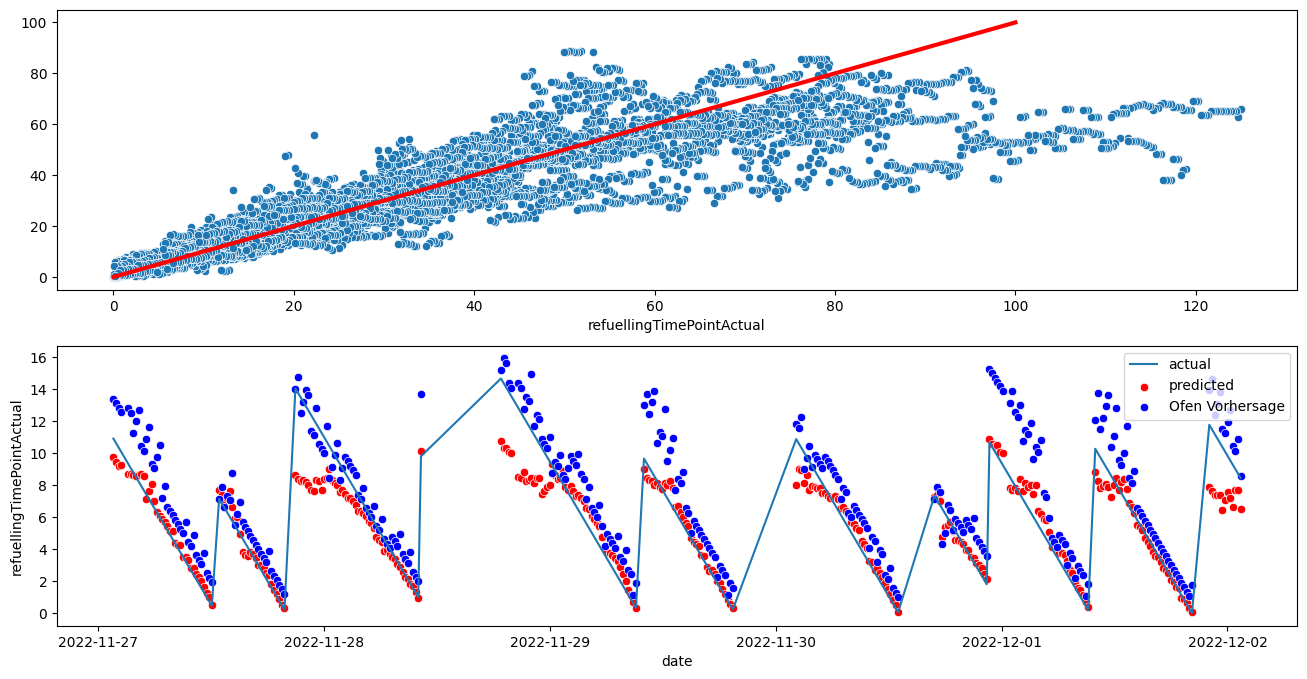

In [5]:
xgboostTrainer.visualize_split()

In [38]:
from sklearn.metrics import mean_absolute_percentage_error

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Regression task
    eval_metric='mape',
    early_stopping_rounds=50,
    n_estimators=1500,
    learning_rate=0.005,
    max_depth=15
    
)

xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

y_pred = xgb_model.predict(X_val)

mape = mean_absolute_percentage_error(y_val, y_pred)
print(f'MAPE: {mape}')

# xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True )
# 
# y_pred = xgb_model.predict(X_test)
# 
# mape = mean_absolute_percentage_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# print(f'Root Mean Squared Error (RMSE): {rmse}')
# print(f'MAPE: {mape}')

[0]	validation_0-mape:0.96928
[1]	validation_0-mape:0.96404
[2]	validation_0-mape:0.95882
[3]	validation_0-mape:0.95363
[4]	validation_0-mape:0.94845
[5]	validation_0-mape:0.94329
[6]	validation_0-mape:0.93819
[7]	validation_0-mape:0.93309
[8]	validation_0-mape:0.92801
[9]	validation_0-mape:0.92298
[10]	validation_0-mape:0.91795
[11]	validation_0-mape:0.91297
[12]	validation_0-mape:0.90800
[13]	validation_0-mape:0.90307
[14]	validation_0-mape:0.89814
[15]	validation_0-mape:0.89329
[16]	validation_0-mape:0.88840
[17]	validation_0-mape:0.88358
[18]	validation_0-mape:0.87873
[19]	validation_0-mape:0.87398
[20]	validation_0-mape:0.86919
[21]	validation_0-mape:0.86445
[22]	validation_0-mape:0.85972
[23]	validation_0-mape:0.85506
[24]	validation_0-mape:0.85042
[25]	validation_0-mape:0.84583
[26]	validation_0-mape:0.84118
[27]	validation_0-mape:0.83666
[28]	validation_0-mape:0.83215
[29]	validation_0-mape:0.82764
[30]	validation_0-mape:0.82319
[31]	validation_0-mape:0.81876
[32]	validation_0-